In [490]:
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib 
import matplotlib.cm as cm
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib as mpl
import pickle as pkl
import os
#from kcrf.estimator import simple_estimator as np_simple_est
import time 
import csv
import torch
from torch.autograd import Variable
import torch.optim as optim
from copy import deepcopy
import pandas as pd

cwd = os.getcwd()
if  os.path.basename(os.path.normpath(cwd))=='notebooks':
    os.chdir("../")

from helpers import load_dictionary

In [491]:
dirname = 'figures/'
os.makedirs(dirname, exist_ok=True)
save_figs = True
def save(n, ext='.pdf', save_figs=True, **kwargs):
    if save_figs==True:
        kwargs.setdefault('bbox_inches', 'tight')
        kwargs.setdefault('pad_inches', 0)
        kwargs.setdefault('transparent', True)
        plt.savefig(os.path.join(dirname, n + ext), **kwargs)
        
def format_ax(ax, xlabel = '',ylabel = '', title= '', labelsize = 20, y_ticks_format='{:,.00%}', x_ticks_format=None):
    vals = ax.get_yticks()
    if y_ticks_format is not None:
        ax.set_yticklabels([y_ticks_format.format(x) for x in vals])
    vals = ax.get_xticks()
    if x_ticks_format is not None:
        if x_ticks_format =='int':
            ax.set_xticklabels([int(x) for x in vals])
        else:
            ax.set_xticklabels([x_ticks_format.format(x) for x in vals])
    ax.set_xlabel(xlabel, fontsize=labelsize)
    ax.set_ylabel(ylabel, fontsize = labelsize)
    ax.yaxis.set_tick_params(labelsize=labelsize)
    ax.xaxis.set_tick_params(labelsize=labelsize)
    ax.set_title(title, size=labelsize)
    #ax.yaxis.set_label_coords(-0.15, 0.5)
    #ax.legend()


In [515]:

def make_all_dirs(root, datasets, models,methods):
    all_paths = [] 
    for d in datasets:
        for m in models:
            for method in methods:
                all_paths.append(os.path.join(root, d, m, method))
    return all_paths


def get_status(reason):
    if reason.startswith('('):
        return 'Queued'
    elif reason.startswith('gpu'):
        return 'Running'
def get_slurm_jobs():
    out = os.popen('squeue -u michaela').read() 
    lines = out.splitlines()
    reader = csv.reader(lines, delimiter=' ')
    out = [ [row[11], row[-1]] for row in reader]
    out = out[1:]
    job_id = [int(a[0]) for a in out]
    status = [get_status(a[1]) for a in out]
    return job_id, status



def get_time_index(x):
    Slurm_id = x.split('_')[1].split('.')[0]
    if not Slurm_id=='':
        Slurm_id = int(Slurm_id)
    else:
        Slurm_id = -1
    return Slurm_id
def get_slurm_index(x):
    Slurm_id = x.split('_')[-1].split('.')[0]
    if not Slurm_id=='':
        Slurm_id = int(Slurm_id)
    else:
        Slurm_id = -1
    return Slurm_id


def get_slurm_status(epoch, file_name, jobs_ids,status, Total_epochs = 1990):
    if epoch >= Total_epochs:
        return 'Done'
    else:
        slurm_id = get_slurm_index(file_name)
        if slurm_id in jobs_ids:
            return 'Running'
        else:
            if slurm_id==-1:
                return 'Unknown'
            else:
                return 'Failed'

def find_last_file_from_path(path):
    if os.path.exists(path):
        files = [file for file in os.listdir(path) if file.startswith('samples')]
        
        if len(files)==0:
            print('No samples files in directory', path)
            return None
    
        else:
            files.sort(key=lambda x:  get_time_index(x) )
            files = [os.path.join(path,file) for file in files]
            return files[-1]
    else:
        return None

def find_best_file_from_path(path):
    if os.path.exists(path):
        files = [os.path.join(path,file) for file in os.listdir(path) if file.startswith('samples')]
        
        if len(files)==0:
            print('No samples files in directory', path)
            return None
    
        else:
            best_file = files[0]
            best_val = 1000000
            for file in files:
                data = extract_result_from_path(file)
                val = get_min_val(data, 'valid_nll')
                if val < best_val and np.isfinite(val):
                    best_val = val
                    best_file = file
            return best_file
    else:
        return None
    
def extract_result_from_path(path):
    try:
        filename = 'stats_seed_0.json'
        full_path = os.path.join(path, filename)
        return load_dictionary(full_path)
    except:
        pass
def get_min_val(out_dic, key):
    try:
        return np.array(out_dic[key]).min()
    except:
        return np.nan
def get_epoch(out_dic):
    try:
        return out_dic['epoch'][-1]
    except:
        return np.nan
    
def make_data_frame(all_paths):
    res = {'dataset':[],
          'model':[],
          'method':[],
          'test_nll':[],
          'epoch':[],
          'path':[],
          'Slurm_status':[],}
    jobs_ids, status = get_slurm_jobs()
    for path in all_paths:
        file = find_last_file_from_path(path)
        #file = find_best_file_from_path(path)
        try:
            data = extract_result_from_path(file)
            path_splits = path.split('/')
            #val = get_min_val(data, 'test_nll')
            if data is not None:
                res['method'].append( path_splits[-1])
                res['model'].append(path_splits[-2])
                res['dataset'].append(path_splits[-3])
                res['epoch'].append(get_epoch(data))
                res['path'].append(file.split('/')[-1])
                res['test_nll'].append(get_min_val(data, 'test_nll'))
                res['Slurm_status'].append(get_slurm_status(get_epoch(data),file.split('/')[-1],jobs_ids,status))
            #print(res)
        except:
            pass
    return res



In [516]:
root = '/nfs/gatsbystor/michaela/projects/kale/exp/neurips/train/'

datasets = ['redwine', 'whitewine', 'parkinsons', 'minibone', 'hepmass']
models = ['nvp']
methods = ['kale', 'donsker', 'cd', 'ml']

all_paths = make_all_dirs(root, datasets, models, methods)
path = all_paths[0]
file = find_last_file_from_path(path)
out_dic = extract_result_from_path(file)

In [517]:
res = make_data_frame(all_paths)

In [518]:
df = pd.DataFrame(res)
df

,dataset,model,method,test_nll,epoch,path,Slurm_status
0,redwine,nvp,kale,12.098695,1240,samples_848866_2154266,Running
1,redwine,nvp,donsker,11.604294,1990,samples_827967_2152389,Done
2,redwine,nvp,cd,12.838659,140,samples_849674_-1,Unknown
3,redwine,nvp,ml,11.808580,1990,samples_827966_2152383,Done
4,whitewine,nvp,kale,13.393676,420,samples_848868_2154267,Running
5,whitewine,nvp,donsker,12.771850,1990,samples_827968_2152390,Done
6,whitewine,nvp,cd,13.927881,50,samples_849676_-1,Unknown
7,whitewine,nvp,ml,13.030018,1990,samples_827966_2152384,Done
8,parkinsons,nvp,kale,14.825373,400,samples_848869_2154268,Running
9,parkinsons,nvp,donsker,13.290758,1970,samples_827968_2152391,Running


In [486]:
path = all_paths[0]
files = [os.path.join(path,file) for file in os.listdir(path) if file.startswith('samples')]
file = files[-1]
data = extract_result_from_path(file)
val = get_min_val(data, 'test_nll')
best_val = 10000
val < best_val and np.isfinite(val)
#data


True

# plots

In [509]:
def get_item( all_paths, items):

    res = {}
    for path in all_paths:
        file = find_last_file_from_path(path)
        try:
            data = extract_result_from_path(file)
            path_splits = path.split('/')
            key = path_splits[-3]+'_'+path_splits[-2]+'_'+path_splits[-1]
            list_res = []
            for item in items:
                list_res.append(data[item])
                res[key] = dict(zip(items, list_res)) 
        except:
            pass
    return res

items =['test_nll', 'log_partition','gt_log_partition', 'epoch']
out_dict=  get_item(all_paths, items)
out_dict

{'redwine_nvp_kale': {'test_nll': [15.443615108728409,
   14.258028626441956,
   13.99474835395813,
   13.80279552936554,
   13.672386646270752,
   13.586144924163818,
   13.501310348510742,
   13.43915843963623,
   13.378244400024414,
   13.355450510978699,
   13.313066959381104,
   13.275922298431396,
   13.224256753921509,
   13.201907396316528,
   13.161441802978516,
   13.16181468963623,
   13.12410843372345,
   13.073805809020996,
   13.046049237251282,
   13.030177593231201,
   13.001604318618774,
   12.999823570251465,
   12.969649910926819,
   12.941060304641724,
   12.92006802558899,
   12.899999380111694,
   12.876488208770752,
   12.851031422615051,
   12.844235897064209,
   12.832543134689331,
   12.802330493927002,
   12.79019582271576,
   12.762900352478027,
   12.751095056533813,
   12.726483345031738,
   12.70493471622467,
   12.703768730163574,
   12.6674644947052,
   12.666211485862732,
   12.652019739151001,
   12.643734455108643,
   12.639777541160583,
   12.613244

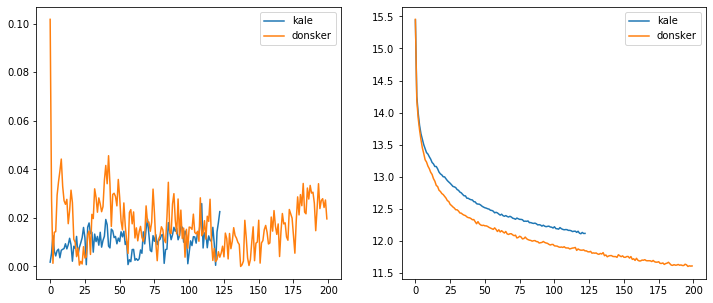

In [510]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

dataset = 'redwine'
model = 'nvp'
method = ['kale', 'donsker']
for m in method:
    key = dataset+'_'+model+'_'+m
    Y = np.array(out_dict[key]['log_partition']) - np.array(out_dict[key]['gt_log_partition'])
    Y = np.abs(Y)
    #X = np.array(out_dict[key]['iter'])
    Z = np.array(out_dict[key]['test_nll'])
    ax[0].plot(Y, label=m)
    ax[1].plot(Z, label=m)
ax[0].legend()
ax[1].legend()







In [514]:
key = dataset+'_'+model+'_'+'kale'
out_dict[key]['log_partition'][-1]

-5.108394622802734